## Design a Penalty Function that Enhances Discrimination in the Latent Space

With this goal in mind, we are going to add a regularizer to the SAE reconstruction cost function, based
on distances. 

Use the same SAE bottleneck layer size as part 1. 

Since we know the number of classes and the label for each input, we can create a set of target points (a prior) in the space of the codes. 

<b> The goal is to design targets to be maximally discriminative i.e. a set of directions (one per class) to help organize the codes when we train the SAE. </b>

We are using more information to train the SAE, so classification should improve. Since during training we know the class of each input, we can measure the distance of the current code to its target and create a penalty for the SAE cost.

To implement this idea, we will create a penalty (R in the figure) as 

### Imports

In [1]:
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch.nn as nn
import numpy as np
import torch
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if not torch.cuda.is_available():
    print("No CUDA Device")
device = device = torch.device("cuda:0")

/home/anthony.rahbany/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libpng16.7f72a3c5.so.16: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Dataset and Dataloader setup
transform = transforms.ToTensor()
kmnst_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

train_idx, test_idx = train_test_split(range(len(kmnst_dataset)), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.20, random_state=42)

train_dataset = Subset(kmnst_dataset, train_idx)
val_dataset = Subset(kmnst_dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

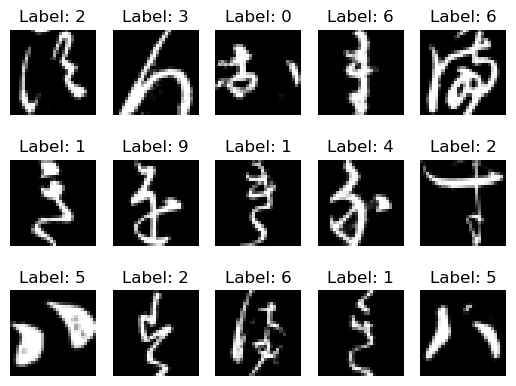

In [3]:
## REMOVE BEFORE SUBMISSION

# Visualization of dataset
batch_idx, (data, target) = next(enumerate(train_loader, 0))

fig = plt.figure()
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(data[i][0], cmap='gray')
    plt.title('Label: {}'.format(target[i]))
    plt.axis(False)

### Model Creation

In [3]:
# Encoder definition (no changes)
class Encoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(Encoder, self).__init__()
        self.encode_dim = bottleneck_size
        self.fc1 = nn.Linear(784, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 400)
        self.bn2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, 200)
        self.bn3 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 100)
        self.bn4 = nn.BatchNorm1d(100)
        self.fc5 = nn.Linear(100, bottleneck_size)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
        
# Decoder definition
class Decoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(bottleneck_size, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 400)
        self.bn3 = nn.BatchNorm1d(400)
        self.fc4 = nn.Linear(400, 800)
        self.bn4 = nn.BatchNorm1d(800)
        self.fc5 = nn.Linear(800, 784)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = torch.sigmoid(self.fc5(x))
        return x

In [ ]:
def train_sae_basic(encoder, decoder, train_loader, criterion, optimizer):
    encoder.train()
    decoder.train()

    instance_count = 0
    train_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        # Access the Data and Labels -> GPU
        data = data.to(device)

        # Zero out the gradients for forward pass
        optimizer.zero_grad()

        # Forward Pass - New Model Predictions
        bottleneck = encoder(data)
        outputs = decoder(bottleneck)

        # Loss Calculation & Back Propagation
        loss = criterion(outputs, data.view(data.size(0), -1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        instance_count += len(labels)

    avg_train_loss = train_loss / instance_count

    return avg_train_loss

In [ ]:
def evalution_sae_basic(encoder, decoder, dataloader, criterion, type="val"):
    encoder.eval()
    decoder.eval()
    
    eval_loss = 0.0
    instance_count = 0
    
    with torch.no_grad():

        for batch_id, (data, labels) in enumerate(dataloader):
            
            # Access the Data and Labels -> GPU
            data = data.to(device)

            # Get Model Predictions
            bottleneck = encoder(data)
            outputs = decoder(bottleneck)

            eval_loss += criterion(outputs, data.view(data.size(0), -1))

            instance_count += len(labels)


        avg_eval_loss = eval_loss / instance_count
    
    return avg_eval_loss

In [ ]:
epochs = 100
patience = 10
learning_rate = 0.001
criterion = nn.MSELoss()
bottleneck_sizes = [8, 16, 32, 64, 128, 256]

for bs in bottleneck_sizes:
    
    encoder = Encoder(bs)    
    decoder = Decoder(bs)
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    # Metrics
    train_accuracies, train_losses = [], []
    val_accuracies, val_losses = [], []

    lowest_loss = 100000000.0
    best_accuracy = -1000000.0
    no_improvement_count = 0

    init_time = time.time()



    """ Staring Training the Autoencoder """

    for epoch in range(epochs):
        model_file_name = "sae_{}.pth".format(bs)

        # train_acc, train_loss = train(encoder, decoder, train_loader, criterion, optimizer)
        train_loss = train_sae_basic(encoder, decoder, train_loader, criterion, optimizer)
        # train_accuracies.append(train_acc)
        train_losses.append(train_loss)

        # val_acc, val_loss = evalution(encoder, decoder, val_loader, criterion, "val")
        val_loss = evalution_sae_basic(encoder, decoder, val_loader, criterion, "val")
        # val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        # print("Epoch: {}/{} | Train Loss: {:.5f} | Train Acc: {:.3f} | Val Acc: {:.3f}".format(epoch, epochs, train_loss, train_acc, val_acc))
        
        print(val_loss)
        if lowest_loss > val_loss.item():
            
            lowest_loss = val_loss.item()
            no_improvement_count = 0
            # test_acc, test_loss, all_preductions, all_labels = evalution(encoder, decoder, test_loader, criterion, "test")
            # cnf_matrix = confusion_matrix(all_labels, all_preductions)
            
            torch.save({
                'epoch': epoch,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'train_losses': train_losses,
                'val_losses': val_losses,
                # 'test_acc': test_acc,
                # 'confusion_matrix': cnf_matrix,
                'time': str(time.time() - init_time),
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict()
            }, model_file_name)

            print("Saving Best Model")
            
        else:
            no_improvement_count += 1
            print("No Improvement: {}".format(no_improvement_count))
        
        print("Epoch: {}/{} | Train Loss: {} | Val Loss: {}".format(epoch, epochs, train_loss, val_loss.item()))

        if no_improvement_count == patience:
            break

In [4]:
# Extract bottleneck features
def extract_features(encoder, data_loader):
    encoder.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            encoded = encoder(images)
            features.append(encoded.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.vstack(features), np.hstack(labels)

In [ ]:
for bn_size in [8, 16, 32, 64, 128, 256]:
    encoder_state_dict = torch.load("sae_{}.pth".format(bn_size), map_location=torch.device('cuda'))
    encoder = Encoder(bottleneck_size=bn_size)
    encoder.load_state_dict(encoder_state_dict['encoder_state_dict'])

    # Extract features for train and test sets
    X_train, y_train = extract_features(encoder, train_loader)
    X_test, y_test = extract_features(encoder, test_loader)

    # Train an SVM classifier
    svm = SVC(kernel='rbf', C=50)
    svm.fit(X_train, y_train)

    # Evaluate the classifier
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f} for Bottleneck Size: {bn_size}")


---

# Latent Space Discrimination

In [72]:
def discrimination_penalty(latent_codes, labels, class_targets, device=None):
    # Euclidian Distance Discrimination

    # Ensure all tensors are on the same device
    if device is None:
        device = latent_codes.device  # Default to latent_codes' device
    
    latent_codes = latent_codes.to(device)
    labels = labels.to(device)
    class_targets = class_targets.to(device)
    
    # Compute distances
    batch_size = latent_codes.size(0)
    distances = torch.zeros(batch_size, device=device)
    
    for i in range(batch_size):
        target = class_targets[labels[i]]  # Get the target for the current class
        distances[i] = torch.norm(latent_codes[i] - target, p=2)  # Compute Euclidean distance

    return distances.mean()


In [31]:
import torch

def cauchy_schwarz_divergence(latent_codes, labels, num_classes, device=None):

    # Determine the device to use
    if device is None:
        device = latent_codes.device  # Default to the latent codes' device

    batch_size, bottleneck_size = latent_codes.size()

    # Move data to the specified device
    labels = labels.to(device)
    latent_codes = latent_codes.to(device)

    # Separate latent codes by class
    class_codes = [latent_codes[labels == c] for c in range(num_classes)]

    # Initialize penalty
    cs_divergence = 0.0

    # Compute pairwise CS divergence between all class pairs
    for i in range(num_classes):
        for j in range(i + 1, num_classes):
            if len(class_codes[i]) > 0 and len(class_codes[j]) > 0:
                P_Q = torch.matmul(class_codes[i], class_codes[j].T).mean()
                P_P = torch.matmul(class_codes[i], class_codes[i].T).mean()
                Q_Q = torch.matmul(class_codes[j], class_codes[j].T).mean()

                # Avoid division by zero
                epsilon = 1e-8
                cs_divergence += -torch.log((P_Q ** 2) / (P_P * Q_Q + epsilon) + epsilon)

    return cs_divergence / num_classes  # Normalize by the number of class pairs


In [33]:
def generate_orthogonal_targets(num_classes, bottleneck_size):
    targets = torch.randn(num_classes, bottleneck_size)
    # Apply Gram-Schmidt orthogonalization
    for i in range(1, num_classes):
        for j in range(i):
            targets[i] -= torch.dot(targets[i], targets[j]) * targets[j]
        targets[i] /= torch.norm(targets[i])
    return targets

In [34]:
def train_latent(encoder, decoder, train_loader, criterion, optimizer, penalty_func, class_targets, lambda_reg):
    encoder.train()
    decoder.train()

    instance_count = 0
    train_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        # Access the Data and Labels -> GPU
        data, labels = data.to(device), labels.to(device)

        # Zero out the gradients for forward pass
        optimizer.zero_grad()

        # Forward Pass - New Model Predictions
        latent_codes = encoder(data)
        reconstructions = decoder(latent_codes)

        # Loss Calculation & Back Propagation
        reconstruction_loss = criterion(reconstructions, data.view(data.size(0), -1))

        if penalty_func == "cs":
            # penalty = cauchy_schwarz_divergence(latent_codes, 0, 1, 64)
            penalty = cauchy_schwarz_divergence(latent_codes, labels, 10, device)
        elif penalty_func == "dis":
            penalty = discrimination_penalty(latent_codes, labels, class_targets, device)

        total_loss = reconstruction_loss + (lambda_reg * penalty)

        train_loss += total_loss.item()
        total_loss.backward()
        optimizer.step()

        instance_count += len(labels)

    avg_train_loss = train_loss / instance_count

    return avg_train_loss

In [35]:
def evalution_latent(encoder, decoder, dataloader, criterion, penalty_func, lambda_reg, class_targets):
    encoder.eval()
    decoder.eval()
    
    eval_loss = 0.0
    instance_count = 0
    
    with torch.no_grad():

        for batch_id, (data, labels) in enumerate(dataloader):
            
            # Access the Data and Labels -> GPU
            data, labels = data.to(device), labels.to(device)

            # Get Model Predictions
            latent_codes = encoder(data)
            reconstructions = decoder(latent_codes)

            reconstruction_loss = criterion(reconstructions, data.view(data.size(0), -1))

            if penalty_func == "cs":
                penalty = cauchy_schwarz_divergence(latent_codes, 0, 1, 64)
            elif penalty_func == "dis":
                penalty = discrimination_penalty(latent_codes, labels, class_targets, device)
            
            total_loss = reconstruction_loss + (lambda_reg * penalty)

            eval_loss += total_loss.item()

            instance_count += len(labels)


        avg_eval_loss = eval_loss / instance_count
    
    return avg_eval_loss

In [40]:
# Extract bottleneck features
def extract_features(encoder, data_loader):
    encoder.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            encoded = encoder(images)
            features.append(encoded.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.vstack(features), np.hstack(labels)

In [37]:
epochs = 100
patience = 10
learning_rate = 0.001
criterion = nn.MSELoss()
bottleneck_sizes = [32, 48, 64, 96, 128]
lambda_reg = [0.01, 0.1, 0.5]
pen_func = "cs"

for bs in bottleneck_sizes:

    for reg in lambda_reg:
        
    
        encoder = Encoder(bs)    
        decoder = Decoder(bs)
        encoder = encoder.to(device)
        decoder = decoder.to(device)
        class_targets = generate_orthogonal_targets(10, bs)
        
        optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

        # Metrics
        train_accuracies, train_losses = [], []
        val_accuracies, val_losses = [], []

        lowest_loss = 100000000.0
        best_accuracy = -1000000.0
        no_improvement_count = 0

        init_time = time.time()

        """ Staring Training the Autoencoder """

        for epoch in range(epochs):
            model_file_name = "sae_bs_{}_reg_{}_pen_{}.pth".format(bs, reg, pen_func)

            train_loss = train_latent(encoder, decoder, train_loader, criterion, optimizer, pen_func, class_targets, reg)
            train_losses.append(train_loss)

            val_loss = evalution_latent(encoder, decoder, val_loader, criterion, pen_func, reg, class_targets)
            val_losses.append(val_loss)

            
            print(val_loss)
            if lowest_loss > val_loss:
            
                lowest_loss = val_loss
                no_improvement_count = 0
                    
                torch.save({
                    'epoch': epoch,
                    'train_accuracies': train_accuracies,
                    'val_accuracies': val_accuracies,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'time': str(time.time() - init_time),
                    'encoder_state_dict': encoder.state_dict(),
                    'decoder_state_dict': decoder.state_dict()
                }, model_file_name)

                print("Saving Best Model")
                
            else:
                no_improvement_count += 1
                print("No Improvement: {}".format(no_improvement_count))
            
            print("Epoch: {}/{} | Train Loss: {} | Val Loss: {}".format(epoch, epochs, train_loss, val_loss))

            if no_improvement_count == patience:
                break

0.0009985834864589076
Saving Best Model
Epoch: 0/100 | Train Loss: 0.000939430983174437 | Val Loss: 0.0009985834864589076
0.0010034538176842034
No Improvement: 1
Epoch: 1/100 | Train Loss: 0.0006786539348346802 | Val Loss: 0.0010034538176842034
0.0010364998880929004
No Improvement: 2
Epoch: 2/100 | Train Loss: 0.0006065672494393463 | Val Loss: 0.0010364998880929004
0.0011365987011231482
No Improvement: 3
Epoch: 3/100 | Train Loss: 0.000558474364564366 | Val Loss: 0.0011365987011231482
0.0012027836715181668
No Improvement: 4
Epoch: 4/100 | Train Loss: 0.0005261266982900755 | Val Loss: 0.0012027836715181668
0.0012194842643414934
No Improvement: 5
Epoch: 5/100 | Train Loss: 0.0004994435435219202 | Val Loss: 0.0012194842643414934
0.0013781015520604948
No Improvement: 6
Epoch: 6/100 | Train Loss: 0.0004799736420197102 | Val Loss: 0.0013781015520604948
0.0015690881153568625
No Improvement: 7
Epoch: 7/100 | Train Loss: 0.0004627680312357067 | Val Loss: 0.0015690881153568625
0.0015026972869721

In [51]:
bottleneck_sizes = [32, 48, 64, 96, 128]
lambda_reg = [0.01, 0.1, 0.5]
pen = "cs"

for bn_size in bottleneck_sizes:
    for reg in lambda_reg:
        model_file_name = "sae_bs_{}_reg_{}_pen_{}.pth".format(bn_size, reg, pen)

        encoder_state_dict = torch.load(model_file_name, map_location=torch.device('cuda'))
        encoder = Encoder(bottleneck_size=bn_size)
        encoder.load_state_dict(encoder_state_dict['encoder_state_dict'])

        # Extract features for train and test sets
        X_train, y_train = extract_features(encoder, train_loader)
        X_test, y_test = extract_features(encoder, test_loader)

        # Train an SVM classifier
        svm = SVC(kernel='rbf', C=50)
        svm.fit(X_train, y_train)

        # Evaluate the classifier
        y_pred = svm.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {accuracy:.4f} for BS: {bn_size} | Reg: {reg} | Lambda: {pen}")


Test Accuracy: 0.7560 for BS: 32 | Reg: 0.01 | Lambda: cs
Test Accuracy: 0.6830 for BS: 32 | Reg: 0.1 | Lambda: cs
Test Accuracy: 0.6123 for BS: 32 | Reg: 0.5 | Lambda: cs
Test Accuracy: 0.7602 for BS: 48 | Reg: 0.01 | Lambda: cs
Test Accuracy: 0.7100 for BS: 48 | Reg: 0.1 | Lambda: cs
Test Accuracy: 0.6255 for BS: 48 | Reg: 0.5 | Lambda: cs
Test Accuracy: 0.7979 for BS: 64 | Reg: 0.01 | Lambda: cs
Test Accuracy: 0.7130 for BS: 64 | Reg: 0.1 | Lambda: cs
Test Accuracy: 0.6541 for BS: 64 | Reg: 0.5 | Lambda: cs
Test Accuracy: 0.7970 for BS: 96 | Reg: 0.01 | Lambda: cs
Test Accuracy: 0.7433 for BS: 96 | Reg: 0.1 | Lambda: cs
Test Accuracy: 0.6823 for BS: 96 | Reg: 0.5 | Lambda: cs
Test Accuracy: 0.7997 for BS: 128 | Reg: 0.01 | Lambda: cs
Test Accuracy: 0.7374 for BS: 128 | Reg: 0.1 | Lambda: cs
Test Accuracy: 0.7115 for BS: 128 | Reg: 0.5 | Lambda: cs


## Retraining with a Different Discriminator

In [ ]:
epochs = 100
patience = 10
learning_rate = 0.001
criterion = nn.MSELoss()
bottleneck_sizes = [64, 96, 128]
lambda_reg = [0.01, 0.1, 0.5]
pen_func = "dis"

for bs in bottleneck_sizes:

    for reg in lambda_reg:
        
    
        encoder = Encoder(bs)    
        decoder = Decoder(bs)
        encoder = encoder.to(device)
        decoder = decoder.to(device)
        class_targets = generate_orthogonal_targets(10, bs)
        
        optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

        # Metrics
        train_accuracies, train_losses = [], []
        val_accuracies, val_losses = [], []

        lowest_loss = 100000000.0
        best_accuracy = -1000000.0
        no_improvement_count = 0

        init_time = time.time()

        """ Staring Training the Autoencoder """

        for epoch in range(epochs):
            model_file_name = "sae_bs_{}_reg_{}_pen_{}.pth".format(bs, reg, pen_func)

            train_loss = train_latent(encoder, decoder, train_loader, criterion, optimizer, pen_func, class_targets, reg)
            train_losses.append(train_loss)

            val_loss = evalution_latent(encoder, decoder, val_loader, criterion, pen_func, reg, class_targets)
            val_losses.append(val_loss)

            
            print(val_loss)
            if lowest_loss > val_loss:
            
                lowest_loss = val_loss
                no_improvement_count = 0
                    
                torch.save({
                    'epoch': epoch,
                    'train_accuracies': train_accuracies,
                    'val_accuracies': val_accuracies,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'time': str(time.time() - init_time),
                    'encoder_state_dict': encoder.state_dict(),
                    'decoder_state_dict': decoder.state_dict()
                }, model_file_name)

                print("Saving Best Model")
                
            else:
                no_improvement_count += 1
                print("No Improvement: {}".format(no_improvement_count))
            
            print("Epoch: {}/{} | Train Loss: {} | Val Loss: {}".format(epoch, epochs, train_loss, val_loss))

            if no_improvement_count == patience:
                break

In [5]:
bottleneck_sizes = [32, 48, 64, 96, 128]
lambda_reg = [0.01, 0.1, 0.5]
pen = "dis"

for bn_size in bottleneck_sizes:
    for reg in lambda_reg:
        model_file_name = "sae_bs_{}_reg_{}_pen_{}.pth".format(bn_size, reg, pen)

        encoder_state_dict = torch.load(model_file_name, map_location=torch.device('cuda'))
        encoder = Encoder(bottleneck_size=bn_size)
        encoder.load_state_dict(encoder_state_dict['encoder_state_dict'])

        # Extract features for train and test sets
        X_train, y_train = extract_features(encoder, train_loader)
        X_test, y_test = extract_features(encoder, test_loader)

        # Train an SVM classifier
        svm = SVC(kernel='rbf', C=50)
        svm.fit(X_train, y_train)

        # Evaluate the classifier
        y_pred = svm.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {accuracy:.4f} for BS: {bn_size} | Reg: {reg} | Lambda: {pen}")


Test Accuracy: 0.9171 for BS: 32 | Reg: 0.01 | Lambda: dis
Test Accuracy: 0.9411 for BS: 32 | Reg: 0.1 | Lambda: dis
Test Accuracy: 0.9455 for BS: 32 | Reg: 0.5 | Lambda: dis
Test Accuracy: 0.9255 for BS: 48 | Reg: 0.01 | Lambda: dis
Test Accuracy: 0.9299 for BS: 48 | Reg: 0.1 | Lambda: dis
Test Accuracy: 0.9435 for BS: 48 | Reg: 0.5 | Lambda: dis
Test Accuracy: 0.9383 for BS: 64 | Reg: 0.01 | Lambda: dis
Test Accuracy: 0.9429 for BS: 64 | Reg: 0.1 | Lambda: dis
Test Accuracy: 0.9424 for BS: 64 | Reg: 0.5 | Lambda: dis
Test Accuracy: 0.9392 for BS: 96 | Reg: 0.01 | Lambda: dis
Test Accuracy: 0.9435 for BS: 96 | Reg: 0.1 | Lambda: dis
Test Accuracy: 0.9333 for BS: 96 | Reg: 0.5 | Lambda: dis
Test Accuracy: 0.9366 for BS: 128 | Reg: 0.01 | Lambda: dis
Test Accuracy: 0.9401 for BS: 128 | Reg: 0.1 | Lambda: dis
Test Accuracy: 0.9418 for BS: 128 | Reg: 0.5 | Lambda: dis


---

## Plotting Latent Space in 3D

In [104]:
import matplotlib.pyplot as plt

def latent_space_3d_plot(encoder, name, test_loader):

    # Get a batch of test data
    idx, (img, target) = next(enumerate(test_loader))
    img = img.to(device)
    
    with torch.no_grad():
        target = target.to(device).cpu().numpy()
        bottleneck = encoder(img).cpu().numpy()

        # Create a 3D plot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        # Latent dimensions
        x = bottleneck[:, 0]
        y = bottleneck[:, 1]
        z = bottleneck[:, 2]
        
        # Scatter plot with colors mapped to targets
        scatter = ax.scatter(x, y, z, c=target, cmap=plt.cm.gist_rainbow, s=40, alpha=0.8)
        
        # Add grid, labels, and title
        ax.set_title(name, fontsize=16, pad=20)
        ax.set_xlabel("Latent Dimension 1", fontsize=12, labelpad=10)
        ax.set_ylabel("Latent Dimension 2", fontsize=12, labelpad=10)
        ax.set_zlabel("Latent Dimension 3", fontsize=12, labelpad=10)
        ax.grid(True)
        
        # Add a color bar
        cbar = fig.colorbar(scatter, ax=ax, pad=0.2, orientation='vertical')
        cbar.set_label("Target Label", fontsize=12)
        
        # Adjust layout and save if specified
        plt.tight_layout()
        plt.show()


### Best Model

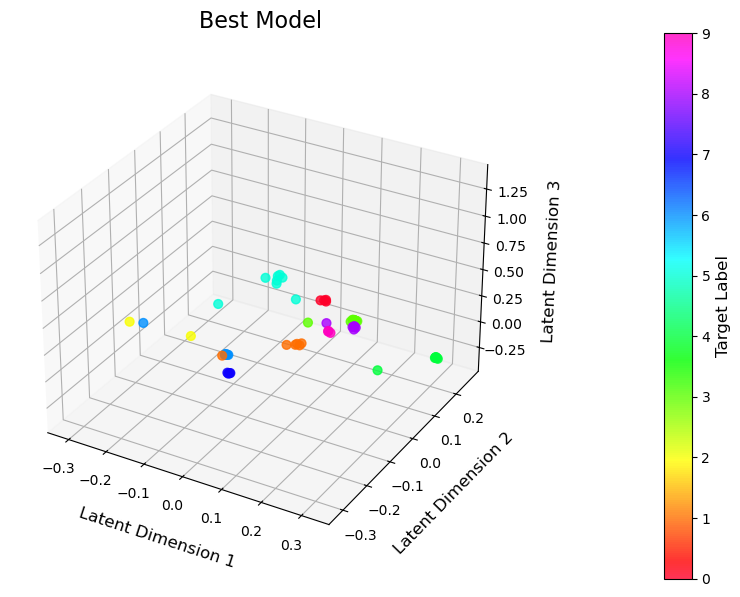

In [105]:
encoder_state_dict = torch.load("sae_bs_32_reg_0.5_pen_dis.pth".format(bn_size), map_location=torch.device('cuda'))
encoder = Encoder(bottleneck_size=32)
encoder.load_state_dict(encoder_state_dict['encoder_state_dict'])
encoder = encoder.to(device)

latent_space_3d_plot(encoder, "Best Model", test_loader)

### Worst Model

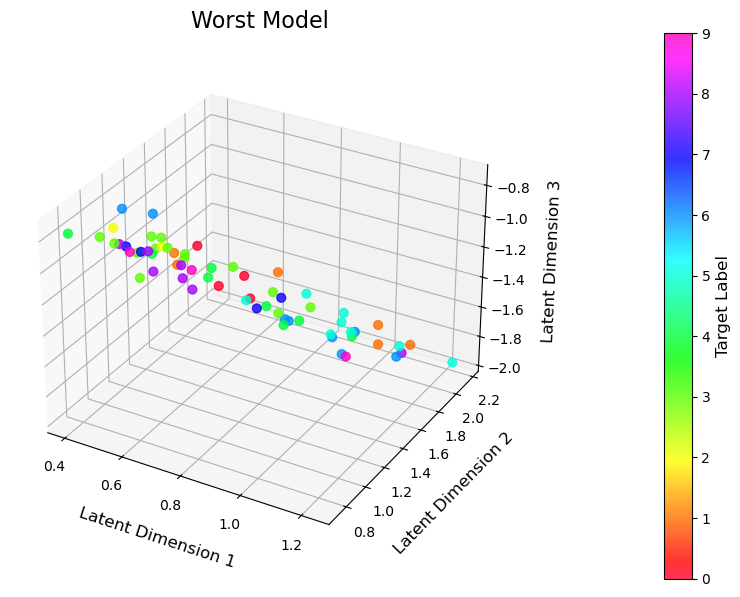

In [106]:
encoder_state_dict = torch.load("sae_bs_32_reg_0.5_pen_cs.pth".format(bn_size), map_location=torch.device('cuda'))
encoder = Encoder(bottleneck_size=32)
encoder.load_state_dict(encoder_state_dict['encoder_state_dict'])
encoder = encoder.to(device)

latent_space_3d_plot(encoder, "Worst Model", test_loader)

### Random Model

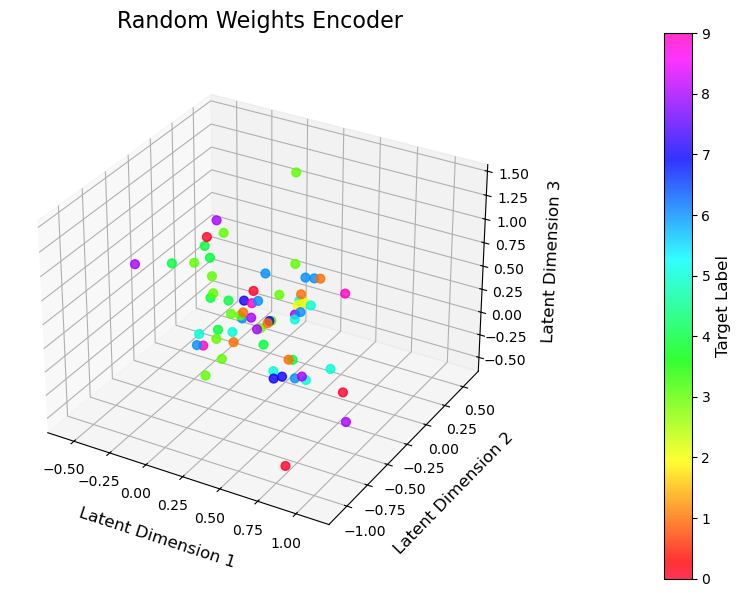

In [107]:
encoder = Encoder(bottleneck_size=32)
encoder = encoder.to(device)

latent_space_3d_plot(encoder, "Random Weights Encoder", test_loader)

## Confusion Matrices & Plots

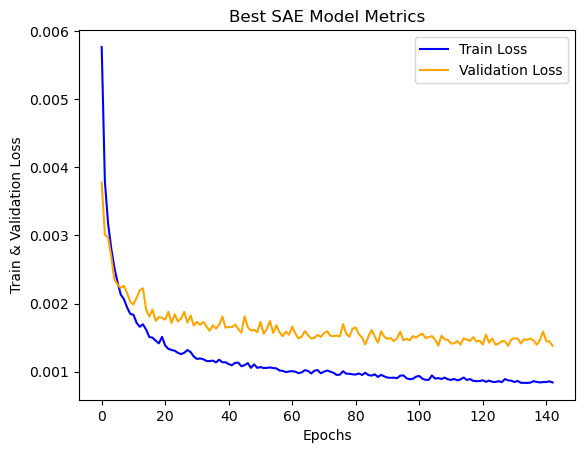

In [117]:
encoder_state_dict = torch.load("sae_bs_32_reg_0.5_pen_dis.pth", map_location=torch.device('cuda'))
encoder = Encoder(bottleneck_size=32)
encoder.load_state_dict(encoder_state_dict['encoder_state_dict'])
encoder = encoder.to(device)

train_losses = encoder_state_dict['train_losses']
val_losses = encoder_state_dict['val_losses']

epochs = range(len(val_losses))

plt.figure()

plt.plot(epochs, train_losses, label="Train Loss", color="blue")
plt.plot(epochs, val_losses, label="Validation Loss", color="orange")

plt.title("Best SAE Model Metrics")
plt.xlabel("Epochs")
plt.ylabel("Train & Validation Loss")
plt.legend()
plt.show()

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

encoder_state_dict = torch.load("sae_bs_32_reg_0.5_pen_dis.pth", map_location=torch.device('cuda'))
encoder = Encoder(bottleneck_size=32)
encoder.load_state_dict(encoder_state_dict['encoder_state_dict'])

# Extract features for train and test sets
X_train, y_train = extract_features(encoder, train_loader)
X_test, y_test = extract_features(encoder, test_loader)

# Train an SVM classifier
svm = SVC(kernel='rbf', C=50)
svm.fit(X_train, y_train)

# Evaluate the classifier
y_pred = svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

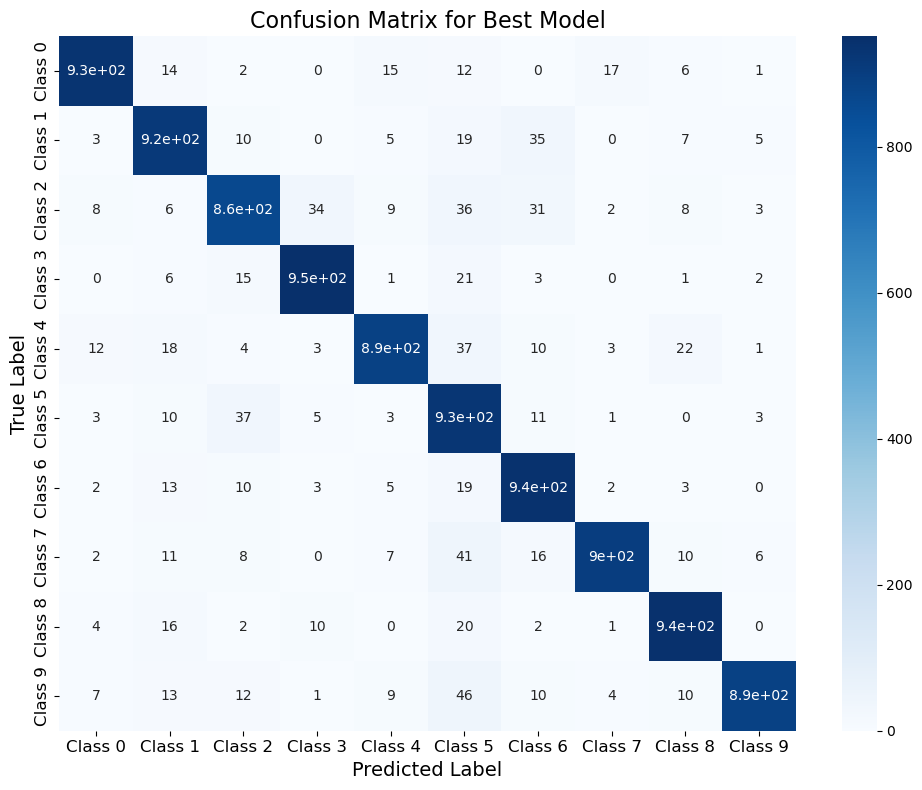

In [123]:
class_names = [f"Class {i}" for i in range(10)]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title  
plt.title("Confusion Matrix for Best Model", fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()
